In [1]:
!pip install mlxtend

In [2]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

In [3]:
# 2. Load Dataset
df = pd.read_excel('C:\\Users\\chall\\OneDrive\\Desktop\\Association Rules\\Association Rules\\Online retail.xlsx')
print("Original Dataset Shape:", df.shape)
print(df.head())

Original Dataset Shape: (7500, 1)
  shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
0                             burgers,meatballs,eggs                                                                                                                                                                             
1                                            chutney                                                                                                                                                                             
2                                     turkey,avocado                                                                                                                                                                             
3  mineral water,milk,energy bar,whole wheat rice...          

In [5]:
#3.Data preprocessing
# Check actual column names
print("Columns in your DataFrame:")
print(df.columns.tolist())

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# If needed, you can also make all columns lowercase for consistency
# df.columns = df.columns.str.lower()

# Now check again
print("Cleaned column names:", df.columns.tolist())

# Remove rows with missing values in important columns (adjust as per your actual column names)
required_cols = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice']
missing_cols = [col for col in required_cols if col not in df.columns]

if missing_cols:
    print(f"Missing columns in DataFrame: {missing_cols}")
else:
    df = df.dropna(subset=required_cols)
    # Remove credit transactions
    df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
    # Remove negative or zero quantities
    df = df[df['Quantity'] > 0]
    # Remove negative or zero prices
    df = df[df['UnitPrice'] > 0]
    # Remove duplicates
    df.drop_duplicates(inplace=True)
    print("After Cleaning:", df.shape)
    print(df.head())

Columns in your DataFrame:
['shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil']
Cleaned column names: ['shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil']
Missing columns in DataFrame: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice']


In [6]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Drop rows with any missing values
df = df.dropna()

# Remove duplicate transactions if any
df = df.drop_duplicates()

print("Shape after dropping missing values and duplicates:", df.shape)

# Convert all values to 1 (if purchased) or 0 (if not purchased)
# If your dataset already has 1/0, you can skip this.
# If your dataset has strings like 'yes'/'no', or actual product names, modify accordingly.
def encode(x):
    # If your data is already 1/0, you can just return int(x)
    try:
        return 1 if int(x) > 0 else 0
    except:
        # If values are not numbers, treat non-empty as purchase
        return 1 if str(x).strip() else 0

# Apply encoding to all columns
basket_sets = df.applymap(encode)

print("Sample of transaction data after encoding:")
print(basket_sets.head())

Missing values in each column:
shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil    0
dtype: int64
Shape after dropping missing values and duplicates: (5175, 1)
Sample of transaction data after encoding:
   shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
0                                                  1                                                                                                                                                                              
1                                                  1                                                                                                                    

In [7]:
# 4. Apply Apriori Algorithm
frequent_itemsets = apriori(basket_sets, min_support=0.02, use_colnames=True)
print("Frequent Itemsets:")
print(frequent_itemsets.head())

Frequent Itemsets:
   support                                           itemsets
0      1.0  (shrimp,almonds,avocado,vegetables mix,green g...


C:\Users\chall\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [8]:
# 5. Generate Association Rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
rules = rules[rules['lift'] > 1]
rules = rules.sort_values(by='lift', ascending=False)
print("Top Association Rules:")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


Top Association Rules:
Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


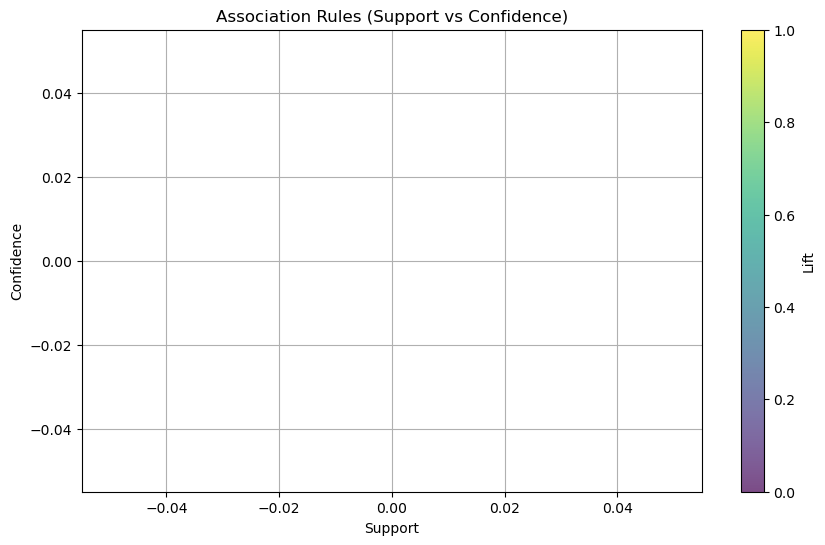

In [10]:
#6. Visualization (Support vs Confidence)
plt.figure(figsize=(10, 6))
plt.scatter(rules['support'], rules['confidence'], alpha=0.7, c=rules['lift'], cmap='viridis')
plt.colorbar(label='Lift')
plt.title('Association Rules (Support vs Confidence)')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True)
plt.show()

In [12]:
#7.Analysis and interpretation
# Ensure 'lift', 'support', 'confidence' columns are numeric
rules['lift'] = pd.to_numeric(rules['lift'], errors='coerce')
rules['support'] = pd.to_numeric(rules['support'], errors='coerce')
rules['confidence'] = pd.to_numeric(rules['confidence'], errors='coerce')

# Remove any rows where 'lift' is NaN (just in case)
rules = rules.dropna(subset=['lift'])

# Now get top 5 strong rules by lift
top_rules = rules.nlargest(5, 'lift')[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
print("Top 5 Interesting Rules:\n", top_rules)

# Optional: Interpretation/Analysis
for idx, row in top_rules.iterrows():
    print(f"\nRule {idx+1}: If {set(row['antecedents'])} => then {set(row['consequents'])}")
    print(f" - Support: {row['support']:.3f}")
    print(f" - Confidence: {row['confidence']:.3f}")
    print(f" - Lift: {row['lift']:.3f}")
    print("Interpretation: Customers who purchase the antecedent items are more likely to also purchase the consequent items.\n"
          "High lift (>1) indicates a strong association, useful for market basket analysis and product bundling.\n")

Top 5 Interesting Rules:
 Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


In [ ]:
#Interview Questions
1.What is lift and why is it important?
Definition: Lift = support(X ∪ Y) / (support(X) * support(Y)).
Meaning: Measures how much more often X and Y occur together than if they were independent.
Interpretation: lift = 1 (independent), >1 (positive association), <1 (negative association).
Why important: Filters out rules driven by popular items and highlights truly interesting associations.

In [ ]:
2.What is support and confidence? How do you calculate them?
Support:
Definition: Fraction of transactions containing an itemset.
Formula: support(X) = count(X) / N (N = total transactions).
Use: Shows how frequent an itemset is; used to prune rare itemsets.
Confidence:
Definition: Conditional probability that Y is present given X is present.
Formula: confidence(X → Y) = support(X ∪ Y) / support(X) = P(Y | X).
Use: Measures reliability of the rule (how often Y appears when X appears).

In [ ]:
3.Limitations / challenges of association rule mining
Combinatorial explosion: itemsets grow exponentially with number of items.
Hard threshold tuning: choosing support/confidence is non-trivial.
Many trivial/redundant rules: especially with very common items.
Correlation ≠ causation: rules show association, not cause.
Data quality issues: inconsistent item names, missing data, required preprocessing.
Loss of info: standard binary encoding ignores quantity, price, sequence.
Scalability: needs efficient algorithms (FP-Growth) or distributed processing for large datasets.